# Environment and image prep
importing all needed packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil
import pandas as pd
import datetime

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory

sliting data in train, val and test data set

In [3]:
now = "/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
def train_test_split():
    print("########### Train Test Val Script started ###########")
    #data_csv = pd.read_csv("DataSet_Final.csv") ##Use if you have classes saved in any .csv file

    root_dir = 'C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2'
    classes_dir = ['No Defect', 'Defect']

    processed_dir = "C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2/Data_not_split"

    val_ratio = 0.10
    test_ratio = 0.10
    os.makedirs(root_dir + now)

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print("$$$$$$$ Class Name " + cls + " $$$$$$$")
        src = processed_dir +"/" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # # Creating Train / Val / Test folders (One time use)
        os.makedirs(root_dir + now +'/train/' + cls)
        os.makedirs(root_dir + now +'/val/' + cls)
        os.makedirs(root_dir + now +'/test/' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + now +'/train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + now +'/val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + now +'/test/' + cls)

    print("########### Train Test Val Script Ended ###########")

train_test_split()

########### Train Test Val Script started ###########
$$$$$$$ Class Name No Defect $$$$$$$
Total images: 1840
Training: 1472
Validation: 184
Testing: 184
$$$$$$$ Class Name Defect $$$$$$$
Total images: 1177
Training: 941
Validation: 118
Testing: 118
########### Train Test Val Script Ended ###########


check data splitting and define data sets

In [4]:
PATH = "C:/Users/matth/switchdrive/HSLU Master/3. sem/Deep Learning in Vision/Project/original_dataset_2" + now + "/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2413 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 302 files belonging to 2 classes.
Found 302 files belonging to 2 classes.


take a look at the images

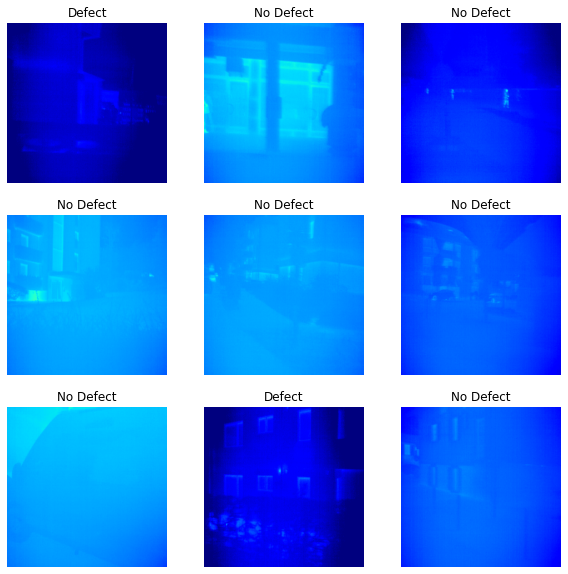

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

optimizing image processing --> image are opened and loaded already during training of last batch

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data augumentation definition.(Not usesed for "best" CNN)

In [8]:
#data_augumentation = daten erweiterung
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#check data augumentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

mobilenetV2 expects pixel values between -1 and 1 --> pictures have to be scaled

In [9]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input


# Loading pretrained CNN and fit it to our pictures / classification


In [10]:
# Create the base model from the pre-trained model MobileNet V2, incluede_top = False --> dense layer for classification of 1000 classes neglected
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


Let's have a look at the MobileNet V2 CNN

In [12]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

creating a layer which streches the output of the MobileNetV2 CNN to a single line vector

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Creating a dense layer which allows to classify the resulting single line vector into two classes. between 0 and 1 = class 1, between -1 and 0 = calss 0

In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Applying the defined data preperation and putting the whole CNN together

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = augumentation(inputs) with augumentation, x = inputs augumentation
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\users\matth\appdata\local\r-mini~1\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

Define parameters for logfile for tensorboard tool

In [17]:
name = f"resnet50{datetime.datetime.now().date()}"
print(name)
tensorboard = TensorBoard(log_dir=f"logs/{name}")



resnet502022-01-17


# 1. Iteration of training the CNN 

In [18]:
#train model
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=tensorboard)

c:\users\matth\appdata\local\r-mini~1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
76/76 [==============================] - 241s 3s/step - loss: 0.8884 - accuracy: 0.4053 - val_loss: 0.7261 - val_accuracy: 0.4437
Epoch 2/10
76/76 [==============================] - 213s 3s/step - loss: 0.7182 - accuracy: 0.5002 - val_loss: 0.6110 - val_accuracy: 0.6391
Epoch 3/10
76/76 [==============================] - 222s 3s/step - loss: 0.6120 - accuracy: 0.6220 - val_loss: 0.5382 - val_accuracy: 0.7483
Epoch 4/10
76/76 [==============================] - 251s 3s/step - loss: 0.5533 - accuracy: 0.6801 - val_loss: 0.4906 - val_accuracy: 0.7947
Epoch 5/10
76/76 [==============================] - 227s 3s/step - loss: 0.5006 - accuracy: 0.7489 - val_loss: 0.4568 - val_accuracy: 0.8245
Epoch 6/10
76/76 [==============================] - 219s 3s/step - loss: 0.4767 - accuracy: 0.7750 - val_loss: 0.4316 - val_accuracy: 0.8344
Epoch 7/10
76/76 [==============================] - 233s 3s/step - loss: 0.4484 - accuracy: 0.7824 - val_loss: 0.4104 - val_accuracy: 0.8311
Epoch 8/10
76

Graphical evaluation of 1. model training

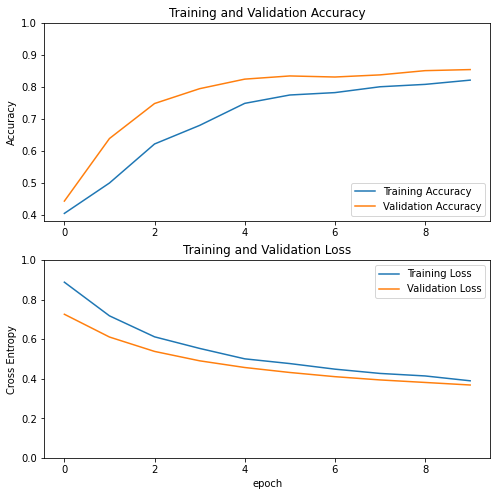

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning of CNN (2. training)
Unfreez the layers 100 till 154

In [24]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

c:\users\matth\appdata\local\r-mini~1\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


check how many variables will be trained

In [25]:
len(model.trainable_variables)

56

fine tuning

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=tensorboard)

Epoch 10/20
76/76 [==============================] - 393s 5s/step - loss: 0.2499 - accuracy: 0.9034 - val_loss: 0.2360 - val_accuracy: 0.9172
Epoch 11/20
76/76 [==============================] - 342s 4s/step - loss: 0.1034 - accuracy: 0.9619 - val_loss: 0.0815 - val_accuracy: 0.9768
Epoch 12/20
76/76 [==============================] - 361s 5s/step - loss: 0.0507 - accuracy: 0.9805 - val_loss: 0.0662 - val_accuracy: 0.9868
Epoch 13/20
76/76 [==============================] - 399s 5s/step - loss: 0.0265 - accuracy: 0.9909 - val_loss: 0.1625 - val_accuracy: 0.9272
Epoch 14/20
76/76 [==============================] - 357s 5s/step - loss: 0.0147 - accuracy: 0.9950 - val_loss: 0.0616 - val_accuracy: 0.9801
Epoch 15/20
76/76 [==============================] - 353s 5s/step - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.0800 - val_accuracy: 0.9868
Epoch 16/20
76/76 [==============================] - 330s 4s/step - loss: 0.0056 - accuracy: 0.9971 - val_loss: 0.0602 - val_accuracy: 0.9901
Epoch 

Graphical evaluation of fine tuning and caluculation of test accuracy

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

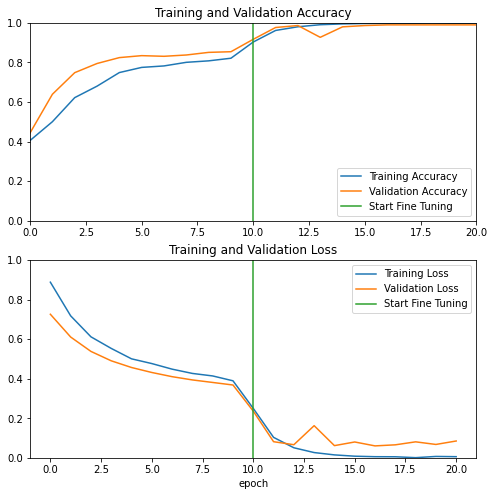

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.xlim([0, 20])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

10/10 [==============================] - 25s 2s/step - loss: 0.0515 - accuracy: 0.9868
Test accuracy : 0.9867549538612366


# Saving model

In [ ]:
model.save('./CNN_saved/resnet50.h5')

# Visualize what CNN learned
load example picture and preprocess it

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2 # if not installed, execute : !pip install opencv-python
# Local path to the target image
img_path = '../original_dataset_2/train/Defect/084407_30.png'
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(224,224))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

In [ ]:
image_class = 1

load saved model

In [ ]:
model = tf.keras.models.load_model('./CNN_saved/mobilenetV2_best.h5')

In [ ]:
class_weights = model.layers[-1].get_weights()[0]
final_conv_layer = model.layers[-3]
    
get_output = tf.keras.backend.function([model.layers[0].input], 
                                       [final_conv_layer.output, model.layers[-1].output])
    
[conv_outputs, predictions] = get_output(x)
conv_outputs = conv_outputs[0, :]

cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

In [ ]:
for index, weight in enumerate(class_weights[:, 0]):
  cam += weight * conv_outputs[index]

In [ ]:
print("predictions", predictions)
img_size = 224
cam /= np.max(cam)
cam = cv2.resize(cam, (img_size, img_size))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_HSV)
heatmap[np.where(cam < 0.2)] = 0
    
img = heatmap * 0.5 + img
cv2.imwrite("heatmap_hsv.jpg", img)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('heatmap_hsv.jpg')
imgplot = plt.imshow(img)
plt.show()